In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
from tqdm import tqdm
import random
import utils


In [ ]:
nodes_gdf = gpd.read_file('Scigrid_data/IGGIN_Nodes.geojson')
nodes_gdf.head()

In [ ]:
pipelines_df = utils.get_IGGIN_pipeline_data()
pipelines_df.head()

### Connecting Norwegian grid to the continent

In [ ]:
# Dunkerque
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_33', 'node_id_1'] = 'INET_N_407'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_33', 'node_id_2'] = 'INET_N_407'

# Zeebrugge
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_5', 'node_id_1'] = 'INET_N_1656'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_5', 'node_id_2'] = 'INET_N_1656'

# Dornum
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_27', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_27', 'node_id_2'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_1'] == 'Storages_0', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'Storages_0', 'node_id_2'] = 'INET_N_379'

# Emden
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_19', 'node_id_1'] = 'INET_N_436'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_19', 'node_id_2'] = 'INET_N_436'

# Easington
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_39', 'node_id_1'] = 'INET_N_410'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_39', 'node_id_2'] = 'INET_N_410'

# St. Fergus
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_24', 'node_id_1'] = 'INET_N_1401'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_24', 'node_id_2'] = 'INET_N_1401'

# In the nodes_gdf, drop the rows with the following ids
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_33']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_5']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_27']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_19']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_39']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_24']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'Storages_0']

### Add attributes (physical properties) to pipelines

In [ ]:
# Create a graph of the pipeline network
G = nx.DiGraph()

# Add the nodes to the graph
for i, row in nodes_gdf.iterrows():
    G.add_node(row['id'], pos=(row['geometry'].x, row['geometry'].y), country_code=row['country_code'], is_country_node=False)

# Add the edges to the graph
for i, row in pipelines_df.iterrows():
    if row['node_id_1'] == row['node_id_2']:
        continue
    G.add_edge(row['node_id_1'], row['node_id_2'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_1'],
                                                    country_code_2= row['country_code_2'],
                                                    name= row['name'])
    if row['is_bothDirection']:
        G.add_edge(row['node_id_2'], row['node_id_1'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_2'],
                                                    country_code_2= row['country_code_1'],
                                                    name= row['name'])

In [ ]:
import os
import pickle

folder_path = 'graph_objects'
os.makedirs(folder_path, exist_ok=True)

with open(os.path.join(folder_path, 'scigrid.pkl'), 'wb') as f:
    pickle.dump(G, f)

In [ ]:
# Print pipelines where country_code_1 is 'NO' and country_code_2 is 'GB'
for row in pipelines_df.itertuples():
    if row.country_code_1 == 'NO' and row.country_code_2 == 'GB':
        # Print the node ids and the name of the pipeline
        print(row.node_id_1, row.node_id_2, row.name)

### Add country nodes to the grid

In [ ]:
G_with_country_nodes = G.copy()

country_positions = {}

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    country_code = node_data.get('country_code')
    if country_code is not None:
        country_code = str.strip(country_code.upper())
    
    if country_code not in country_positions:
        country_positions[country_code] = []
    country_positions[country_code].append(node_data['pos'])

for country_code, positions in country_positions.items():
    average_position = np.mean(positions, axis=0)
    G_with_country_nodes.add_node(country_code, pos=average_position, is_country_node=True, country_code=country_code)

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    if 'country_node' in node_data:
        G_with_country_nodes.remove_node(node_id)

### Direct dead-end flow from nodes to their respective country nodes 

In [ ]:
# Get the list of country nodes
country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]

# Iterate over each node in the graph
for node_id, node_data in G_with_country_nodes.nodes(data=True):
    # Skip country nodes
    if node_data.get('is_country_node'):
        continue
    
    # Get the country code of the node
    country_code = node_data.get('country_code')
    
    # Find the corresponding country super node
    country_super_node = next((cn for cn in country_nodes if G_with_country_nodes.nodes[cn]['country_code'] == country_code), None)
    
    if country_super_node:
        # Check if the node is a sink (only incoming edges)
        if G_with_country_nodes.in_degree(node_id) > 0 and G_with_country_nodes.out_degree(node_id) == 0:
            # Calculate the aggregate in-degree capacity of the child node
            aggregate_in_capacity = sum(G_with_country_nodes.edges[neighbor, node_id]['capacity'] for neighbor in G_with_country_nodes.predecessors(node_id))
            
            # Add an edge directed towards the country node from the node with the aggregate in-degree capacity
            G_with_country_nodes.add_edge(node_id, country_super_node, capacity = aggregate_in_capacity)
        
        
        # Check if the node is a source (only outgoing edges)
        if G_with_country_nodes.in_degree(node_id) == 0 and G_with_country_nodes.out_degree(node_id) > 0:
            # Calculate the aggregate out-degree capacity of the child node
            aggregate_out_capacity = sum(G_with_country_nodes.edges[node_id, neighbor]['capacity'] for neighbor in G_with_country_nodes.successors(node_id))
            
            # Add an edge directed towards the node from the country node with the aggregate out-degree capacity
            G_with_country_nodes.add_edge(country_super_node, node_id, capacity = aggregate_out_capacity) 


In [ ]:
import matplotlib.image as mpimg
europe_map = mpimg.imread('Europe_blank_map.png')

plt.figure(figsize=(15, 10))
plt.imshow(europe_map, extent=[-20, 40, 35, 70], alpha=0.5)

pos = nx.get_node_attributes(G_with_country_nodes, 'pos')
node_colors = ['red' if G_with_country_nodes.nodes[node_id].get('is_country_node') else 'lightblue' for node_id in G_with_country_nodes.nodes]
nx.draw(G_with_country_nodes, pos=pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', width=1, alpha=0.7)

country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]
nx.draw_networkx_labels(G_with_country_nodes, pos=pos, labels={node_id: node_id for node_id in country_nodes}, font_color='black', font_size=8)

plt.show()

### Max flow testing

In [ ]:
sources = ['NO', 'RU']
sinks = ['DE', 'FR']

flow_val, flow_dict, flow_edges = utils.max_flow(G_with_country_nodes, sources, sinks)

----
# Cai et al. 2021
### Capacity robustnes based on maximum flow.

In [ ]:
import random

def W(flow_dict):
    """ 
    Computes flow matrix W after running max flow algorithm on the graph.
    Defined in Cai et al. (2021) as the flow matrix of the network prior to any node removal.
    
    Returns:
        flow_matrix: 2D numpy array representing the flow matrix
        node_indices: Dictionary mapping nodes to their corresponding indices
    """
    nodes = list(flow_dict.keys())
    num_nodes = len(nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    flow_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                flow_matrix[i, j] = flow_dict.get(nodes[i], {}).get(nodes[j], 0)
    
    return flow_matrix, node_indices


def W_c(flow_matrix, target, node_indices):
    """
    Computes the flow matrix W_c after removing a node.
    Defined in Cai et al. (2021) as the original flow matrix of the network after removing entry corresponding to the removed node.

    Parameters:
        flow_matrix: Flow matrix of the original graph
        target: Target can be either a single node or an edge in the form (v1, v2)
        node_indices: Dictionary mapping nodes to their indices in the flow matrix

    Returns:
        flow_matrix_c: Flow matrix after removing the specified node
        modified_flow_matrix: Modified flow matrix
    """

    modified_flow_matrix = np.copy(flow_matrix)

    if isinstance(target, (set,tuple)) and len(target) == 2:
        # Target is an edge in the form (v1, v2)
        v1, v2 = target
        index_v1 = node_indices.get(v1, None)
        index_v2 = node_indices.get(v2, None)

        if index_v1 is not None and index_v2 is not None:
            modified_flow_matrix[index_v1, index_v2] = 0
            modified_flow_matrix[index_v2, index_v1] = 0
    
    else:
        # Target is a single node
        removed_node_index = node_indices.get(target, None)

        # Exclude the row and column corresponding to the removed node
        if removed_node_index is not None and removed_node_index < modified_flow_matrix.shape[0]:
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=0)
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=1)

    return modified_flow_matrix

def check_validity(heuristic, remove, k_removals):
        if heuristic not in ['random', 'greedy', 'max_flow']:
            raise ValueError("Invalid heuristic")
        if remove not in ['node', 'edge']:
            raise ValueError("Invalid removal type")
        if not isinstance(k_removals, int) or k_removals < 1:
            raise ValueError("Invalid number of removals")
        if remove=='edge' and G.number_of_edges() < k_removals:
            raise ValueError("Too many edges to remove")
        if remove=='node' and G.number_of_nodes() < k_removals:
            raise ValueError("Too many nodes to remove")


In [ ]:
def flow_capacity_robustness(G_, sources, sinks, k_removals, heuristic='random', remove='node', n_benchmarks = 100, all_to_all_flow=False):
    """ 
    Computes the n-k capacity robustness based on maximum flow of a graph
    Defined in Cai et al. (2021) as: sum(W_c_prime) / sum(W_c)
    """

    # Check the validity of the input arguments
    check_validity(heuristic, remove, k_removals)

    G = G_.copy()

    # Remove the country node abstractions from the graph
    country_nodes = [n for n in G.nodes if G.nodes[n].get('is_country_node') and n not in sources and n not in sinks]
    G.remove_nodes_from(country_nodes)

    if all_to_all_flow:
        G.remove_nodes_from([n for n in G.nodes if G.nodes[n].get('is_country_node')])
        sources = [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) > 0]
        sinks = [n for n in G.nodes() if G.out_degree(n) == 0 and G.in_degree(n) > 0]

    # Calculate the original flow matrix W of the graph
    flow_val, flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
    flow_matrix, node_indices = W(flow_dict)

    # Instantiate the results dataframe
    results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity', 'entity_data', 'sources', 'sinks', 'network_state', 'flow_dict', 'comment'])
    results_df.loc[0] = [flow_val, 1, None, None, None, sources, sinks, G.copy(), flow_dict, 'No removals made']

    # Helper function to check if a node is valid
    def node_is_valid(n, sources, sinks, g):
        return n not in sources and n not in sinks and n != 'super_source' and n != 'super_sink' and n in g.nodes()
    
    # Helper function to check if an edge is valid
    def edge_is_valid(src, snk, sources, sinks, g):
        return src not in sources and snk not in sinks and src != 'super_source' and snk != 'super_sink' and (src, snk) in g.edges() 
    
    if heuristic == 'random':
        G_lst = [G.copy() for _ in range(n_benchmarks)]
        G_flow_matrix_lst = [flow_matrix for _ in range(n_benchmarks)]

    # N-k capacity robustness calculation
    for k in tqdm(range(1, k_removals + 1), desc='N-k capacity robustness'):

        if heuristic == 'random':
            max_flow_lst, capacity_robustness_lst = [], []

            for G_copy, G_flow_matrix in zip(G_lst, G_flow_matrix_lst):

                valid_targets = [target for target in (G_copy.nodes() if remove == 'node' else G_copy.edges()) if node_is_valid(target, sources, sinks, G_copy) or edge_is_valid(target[0], target[1], sources, sinks, G_copy)]
                target = random.choice(valid_targets)
                
                if remove == 'edge':
                    target_data = G_copy.get_edge_data(*target)
                    G_copy.remove_edge(*target)
                else:
                    target_data = G_copy.nodes[target]
                    G_copy.remove_node(target)

                G_flow_matrix = W_c(G_flow_matrix, target, node_indices)
                W_c_ = G_flow_matrix

                current_max_flow_val, current_flow_dict, _ = utils.max_flow(G_copy, sources, sinks, show_plot=False)
                W_c_prime, _ = W(current_flow_dict)

                capacity_robustness_lst.append(np.sum(W_c_prime) / np.sum(W_c_))
                max_flow_lst.append(current_max_flow_val)

            results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target, target_data, sources, sinks, G_copy.copy(), current_flow_dict,'Specimen graph, averaged across '+str(n_benchmarks)+' benchmarks']

        
        elif heuristic == 'greedy':
            # Project thesis...
            raise NotImplementedError
        

        elif heuristic == 'max_flow':
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)


            # Find the edge that maximizes the flow
            max_flow, target = float('-inf'), None
            max_flow, target = max(((flow, (source, sink)) for source, edges in current_flow_dict.items() for sink, flow in edges.items() if edge_is_valid(source, sink, sources, sinks, G) and node_is_valid(source, sources, sinks, G) and flow > max_flow), key=lambda x: x[0], default=(float('-inf'), None))
    
            if remove == 'edge':
                target_data = G.get_edge_data(*target)
                G.remove_edge(*target)
            else:
                target = target[0]
                target_data = G.nodes[target]
                G.remove_node(target)


            # Calculate the flow matrix W_c after removing the node or edge
            flow_matrix = W_c(flow_matrix, target, node_indices)
            W_c_ = flow_matrix

            # Recompute W_c_prime (flow matrix) after the network has sustained damage
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
            W_c_prime, _ = W(current_flow_dict)

            results_df.loc[k] = [current_max_flow_val, np.sum(W_c_prime) / np.sum(W_c_), 'max_flow', target, target_data, sources, sinks, G.copy(), current_flow_dict, None]

            
        # Other heuristics

        else:
            raise ValueError("Invalid heuristic")


    return results_df

In [ ]:
n_benchmarks = 50

sources = ['NO', 'RU']
sinks = ['DE', 'FR']

## Random heuristic

### Node removal

#### All-to-all flow

In [ ]:
# random_node_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='node', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# random_node_removal_all_to_all_df.to_pickle('results/random_node_removal_all_to_all_df.pkl')

random_node_removal_all_to_all_df = pd.read_pickle('results/random_node_removal_all_to_all_df.pkl')
random_node_removal_all_to_all_df

In [ ]:
utils.plot_biplot(random_node_removal_all_to_all_df)

#### Geopolitical flow

In [ ]:
# random_node_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='node', n_benchmarks=n_benchmarks)
# random_node_removal_geopolitical_df.to_pickle('results/random_node_removal_geopolitical_df.pkl')

random_node_removal_geopolitical_df = pd.read_pickle('results/random_node_removal_geopolitical_df.pkl')
random_node_removal_geopolitical_df

In [ ]:
utils.plot_biplot(random_node_removal_geopolitical_df)

### Edge removal

#### All-to-all flow

In [ ]:
# random_edge_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='edge', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# random_edge_removal_all_to_all_df.to_pickle('results/random_edge_removal_all_to_all_df.pkl')

random_edge_removal_all_to_all_df = pd.read_pickle('results/random_edge_removal_all_to_all_df.pkl')
random_edge_removal_all_to_all_df

In [ ]:
utils.plot_biplot(random_edge_removal_all_to_all_df)

#### Geopolitical flow

In [ ]:
# random_edge_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='edge', n_benchmarks=n_benchmarks)
# random_edge_removal_geopolitical_df.to_pickle('results/random_edge_removal_geopolitical_df.pkl')

random_edge_removal_geopolitical_df = pd.read_pickle('results/random_edge_removal_geopolitical_df.pkl')
random_edge_removal_geopolitical_df

In [ ]:
utils.plot_biplot(random_edge_removal_geopolitical_df)

## Max flow heuristic

### Node removal

#### All-to-all flow

In [ ]:
# max_flow_node_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=150, heuristic='max_flow', remove='node', all_to_all_flow=True)
# max_flow_node_removal_all_to_all_df.to_pickle('results/max_flow_node_removal_all_to_all_df.pkl')

max_flow_node_removal_all_to_all_df = pd.read_pickle('results/max_flow_node_removal_all_to_all_df.pkl')
max_flow_node_removal_all_to_all_df

In [ ]:
utils.plot_biplot(max_flow_node_removal_all_to_all_df)

#### Geopolitical flow

In [ ]:
# max_flow_node_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=10, heuristic='max_flow', remove='node')
# max_flow_node_removal_geopolitical_df.to_pickle('results/max_flow_node_removal_geopolitical_df.pkl')

max_flow_node_removal_geopolitical_df = pd.read_pickle('results/max_flow_node_removal_geopolitical_df.pkl')
max_flow_node_removal_geopolitical_df

In [ ]:
utils.plot_biplot(max_flow_node_removal_geopolitical_df)

### Edge removal

#### All-to-all flow

In [ ]:
# max_flow_edge_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='max_flow', remove='edge', all_to_all_flow=True)
# max_flow_edge_removal_all_to_all_df.to_pickle('results/max_flow_edge_removal_all_to_all_df.pkl')

max_flow_edge_removal_all_to_all_df = pd.read_pickle('results/max_flow_edge_removal_all_to_all_df.pkl')
max_flow_edge_removal_all_to_all_df

In [ ]:
utils.plot_biplot(max_flow_edge_removal_all_to_all_df)

#### Geopolitical flow

In [ ]:
# max_flow_edge_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=10, heuristic='max_flow', remove='edge')
# max_flow_edge_removal_geopolitical_df.to_pickle('results/max_flow_edge_removal_geopolitical_df.pkl')

max_flow_edge_removal_geopolitical_df = pd.read_pickle('results/max_flow_edge_removal_geopolitical_df.pkl')
max_flow_edge_removal_geopolitical_df

In [ ]:
utils.plot_biplot(max_flow_edge_removal_geopolitical_df)

----
# Iterative visualization of flow capacity robustness

In [ ]:
utils.visualize_network_state(random_node_removal_geopolitical_df, iteration=230, only_flow_edges=False)

In [ ]:
utils.visualize_network_state(max_flow_edge_removal_geopolitical_df, iteration=3, only_flow_edges=True)

----
# Flow recovery 

### Cai et al. (2021) flow recovery pseudo-code

    Program Network Recovery
        For vj in Vs
            For vi in Vd
                If is Adjacent (vi, vj)  True
                    add node vi to network G
                    add edge {vi, vj} to network G
                End If
            End For
        End For
    End Network Recovery

vj and ni are adjacent nodes. Vd set of damaged nodes. Vs set of remaining nodes after n-k.

In [177]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def flow_recovery(results_df_, plot_recovery=True):
    """
    Run the recovery algorithm on the network.
    """

    # Copy the results dataframe
    results_df = results_df_.copy()

    # Instantiate the recovery (results) dataframe
    recovery_df = pd.DataFrame(columns=['damage_rate', 'flow_recovery', 'flow_improvement_rate', 'recovered_grid_size'])

    # Helper function to recover the network
    def recover(df_, iteration):
        """
        Flow recovery algorithm to recover the network after damage.
        Defined in Cai et al. (2021).  
        """

        df = df_.copy()

        damaged_network = df.loc[iteration, 'network_state'].copy()
        undamaged_network = df.loc[0, 'network_state'].copy()

        # Set of remaining nodes
        Vs = list(damaged_network.nodes())

        # Set of damanged (removed) nodes
        Vd = list(undamaged_network.nodes() - damaged_network.nodes())

        reinstated_nodes = []

        # Flow recovery
        # First, add nodes to reinstate network structure
        for vj in Vs:
            for vi in Vd:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_node(vi, pos=undamaged_network.nodes[vi]['pos'], is_country_node=False, recovered_entity=True)
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                    reinstated_nodes.append(vi)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_node(vi, pos=undamaged_network.nodes[vi]['pos'], is_country_node=False, recovered_entity=True)
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)
                    reinstated_nodes.append(vi)

        # Add edges between set of reinstated nodes
        for vi in reinstated_nodes:
            for vj in reinstated_nodes:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)
        
        # Add edges between reinstated nodes and (previously) remaining nodes
        for vi in reinstated_nodes:
            for vj in Vs:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)

        # Damaged network now undergone recovery
        recovered_network = damaged_network

        damaged_flow_val = df.loc[iteration, 'max_flow_value']
        recovered_flow_val, _, _ = utils.max_flow(recovered_network, df.loc[0, 'sources'], df.loc[0, 'sinks'], show_plot=False)

        return df.loc[0, 'max_flow_value'], damaged_flow_val, recovered_flow_val, recovered_network

    init_num_nodes = results_df.loc[0, 'network_state'].number_of_nodes()

    for i in tqdm(range(1, results_df.shape[0]), desc='Recovery process'):
        optimal_max_flow, damaged_flow_val, recovered_flow_val, recovered_network = recover(results_df, iteration=i)

        damage_rate = 1 - results_df.loc[i, 'network_state'].number_of_nodes() / init_num_nodes
        flow_recovery = recovered_flow_val / optimal_max_flow
        flow_improvement_rate = None if damaged_flow_val == 0 else sigmoid(recovered_flow_val/damaged_flow_val)
        recovered_grid_size = recovered_network.number_of_nodes() / init_num_nodes

        recovery_df.loc[i] = [damage_rate, flow_recovery, flow_improvement_rate, recovered_grid_size]

    if plot_recovery:
        reversed_recovery_df = recovery_df.iloc[::-1].reset_index(drop=True)

        plt.figure(figsize=(10, 6))
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['flow_recovery'], label='flow recovery (relative to optimal)')
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['flow_improvement_rate'], label='flow improvement (relative to flow at current grid damage rate)')
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['recovered_grid_size'], label='size of recovered grid (relative to initial grid size)')
        
        plt.xlabel('Grid damage rate (pct. nodes removed)')
        plt.ylabel('Recovery')
        plt.title('Flow recovery')

        # Reverse the x-axis scale
        plt.gca().invert_xaxis()

        plt.legend()
        plt.show()

    return recovery_df

### Node, random heuristic, all-to-all flow

Recovery process: 100%|██████████| 250/250 [01:04<00:00,  3.89it/s]


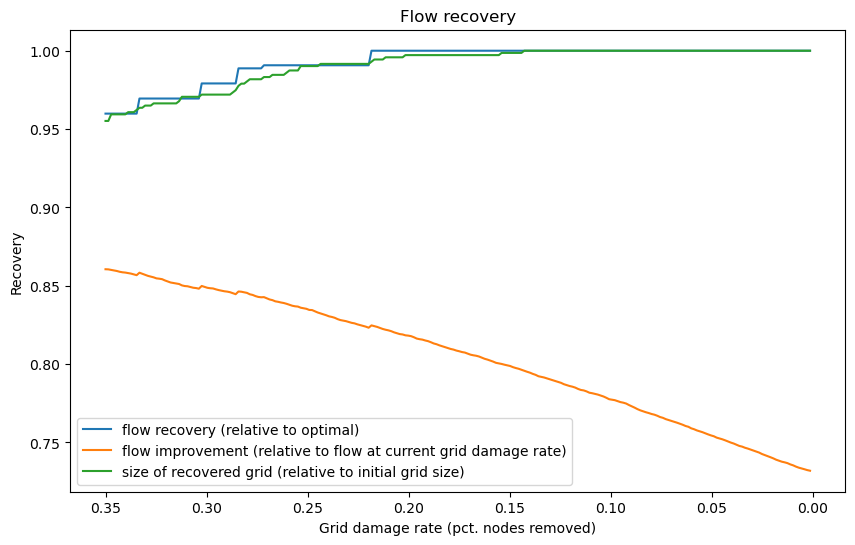

In [178]:
random_node_removal_all_to_all_recovery_df = flow_recovery(random_node_removal_all_to_all_df, plot_recovery=True)

### Node, random heuristic, geopolitical flow

Recovery process: 100%|██████████| 250/250 [00:52<00:00,  4.79it/s]


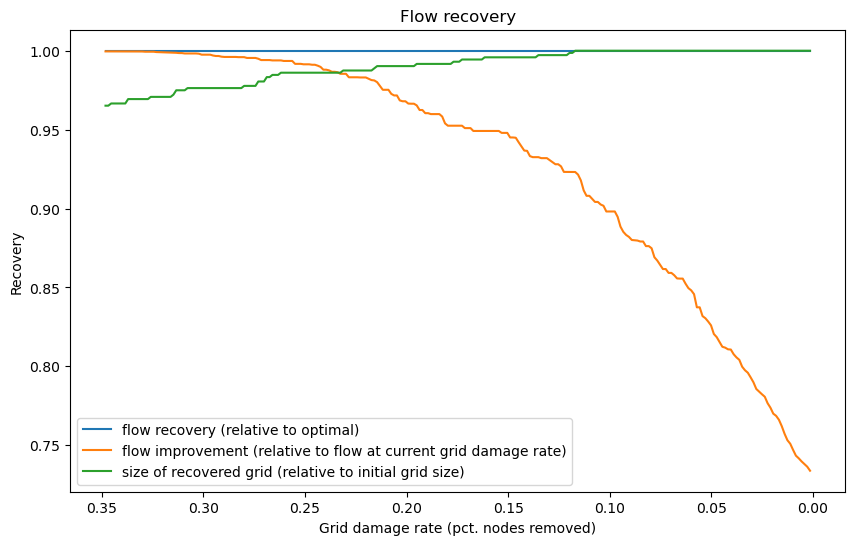

In [179]:
random_node_removal_geopolitical_recovery_df = flow_recovery(random_node_removal_geopolitical_df, plot_recovery=True)

### Node, max_flow heuristic, all-to-all flow

Recovery process: 100%|██████████| 150/150 [00:34<00:00,  4.37it/s]


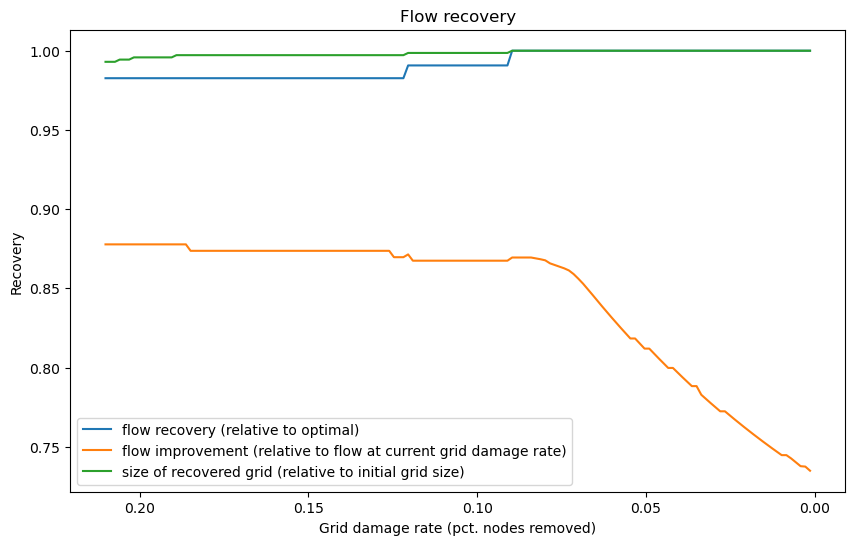

In [180]:
max_flow_node_removal_all_to_all_recovery_df = flow_recovery(max_flow_node_removal_all_to_all_df, plot_recovery=True)

### Node, max flow heuristic, geopolitical flow

Recovery process:   0%|          | 0/10 [00:00<?, ?it/s]

Recovery process: 100%|██████████| 10/10 [00:00<00:00, 24.16it/s]


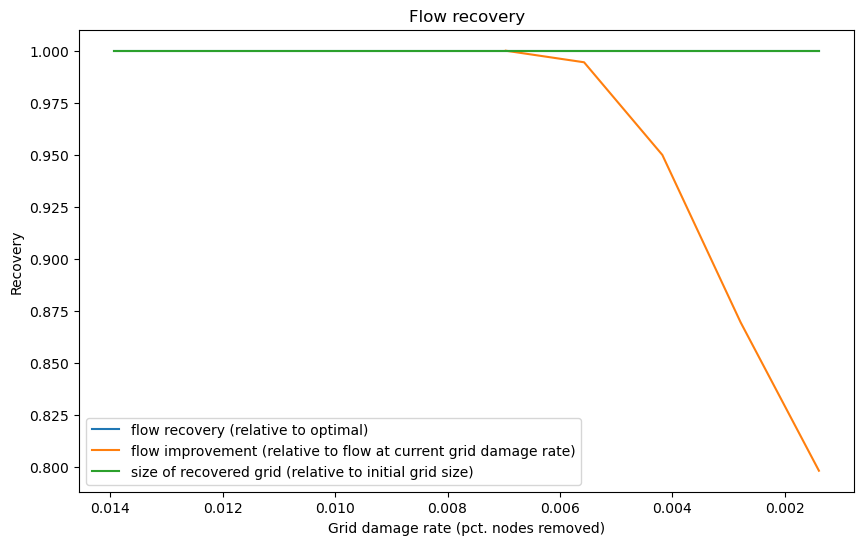

In [181]:
max_flow_node_removal_geopolitical_recovery_df = flow_recovery(max_flow_node_removal_geopolitical_df, plot_recovery=True)